# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Data Exploration - general population vs. customers

#### Load general population and customers dataset

In [2]:
# load in the data
# general population dataset
azdias_df = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

# customers dataset
customers_df = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/home/fc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [6]:
customers_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


`azdias_df` and `customers_df` have 366 common features, which is the same as `azdias_df` features.

In [7]:
np.intersect1d(azdias_df.columns.values, customers_df.columns.values).shape

(366,)

create `only_attr_customers` to hold `customer_df` only features

In [8]:
only_attr_customers = np.setdiff1d(customers_df.columns.values, azdias_df.columns.values)
only_attr_customers

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

CUSTOMER_GROUP distribution

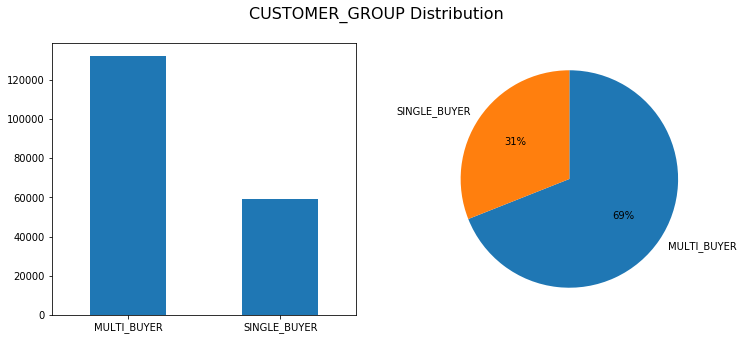

In [9]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.CUSTOMER_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.CUSTOMER_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('CUSTOMER_GROUP Distribution', fontsize=16)
plt.show()

ONLINE_PURCHASE distribution

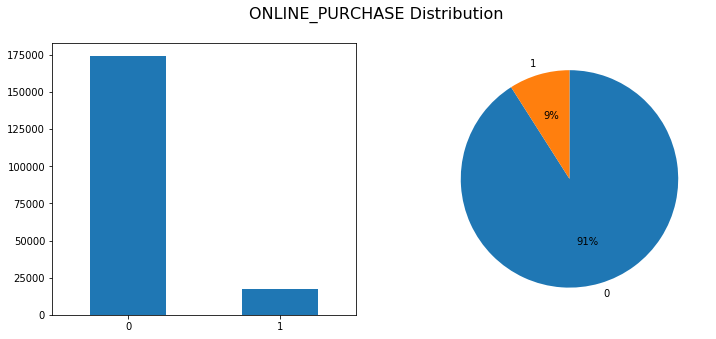

In [10]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.ONLINE_PURCHASE.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.ONLINE_PURCHASE.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('ONLINE_PURCHASE Distribution', fontsize=16)
plt.show()

PRODUCT_GROUP distribution

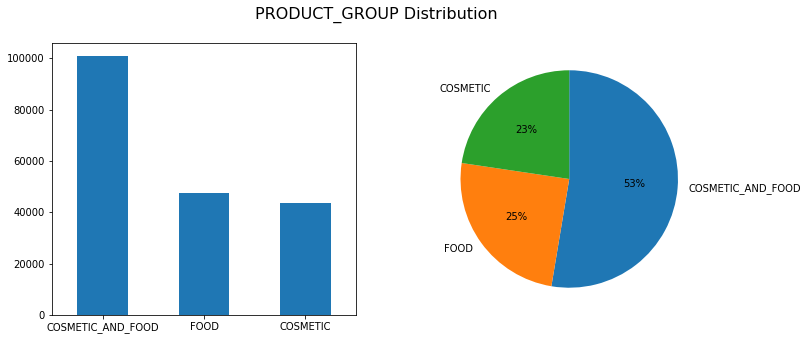

In [11]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.PRODUCT_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.PRODUCT_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('PRODUCT_GROUP Distribution', fontsize=16)
plt.show()

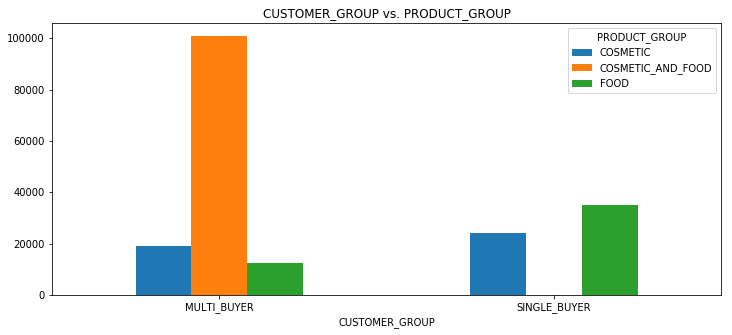

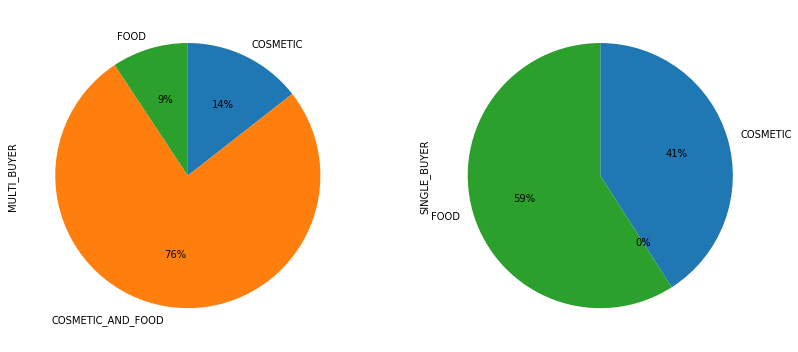

In [12]:
customers_df.groupby(['CUSTOMER_GROUP'])['PRODUCT_GROUP'].value_counts().unstack().plot.bar(figsize = [12, 5], rot=0).set_title('CUSTOMER_GROUP vs. PRODUCT_GROUP')

customers_df.groupby(['CUSTOMER_GROUP'])['PRODUCT_GROUP'].value_counts().unstack().T.plot.pie(subplots=True, autopct='%1.f%%', figsize=[12,5], legend=False, startangle = 90, counterclock = False)

plt.tight_layout()
plt.show()

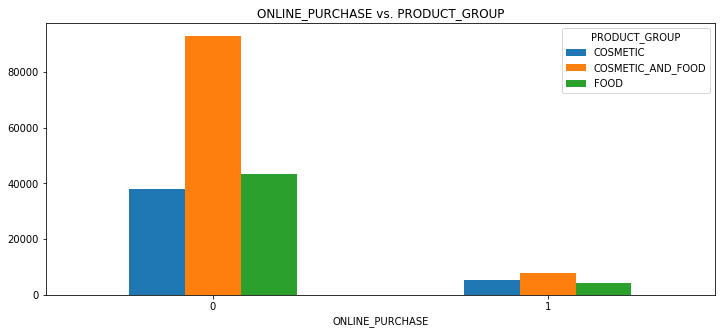

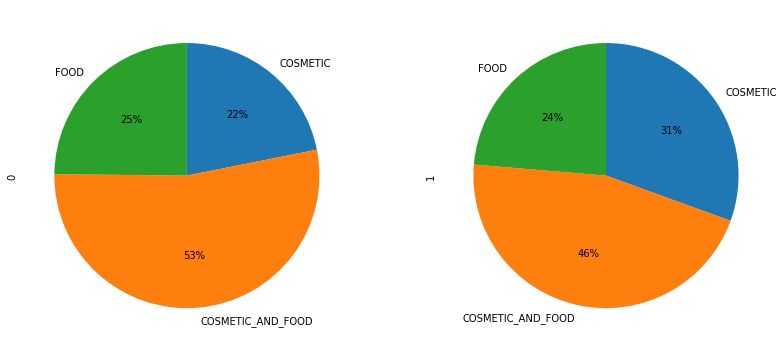

In [13]:
customers_df.groupby(['ONLINE_PURCHASE'])['PRODUCT_GROUP'].value_counts().unstack().plot.bar(figsize = [12, 5], rot=0).set_title('ONLINE_PURCHASE vs. PRODUCT_GROUP')

customers_df.groupby(['ONLINE_PURCHASE'])['PRODUCT_GROUP'].value_counts().unstack().T.plot.pie(subplots=True, autopct='%1.f%%', figsize=[12,5], legend=False, startangle = 90, counterclock = False)

plt.tight_layout()
plt.show()

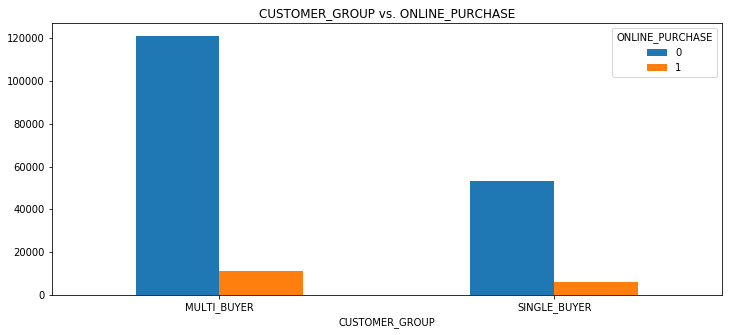

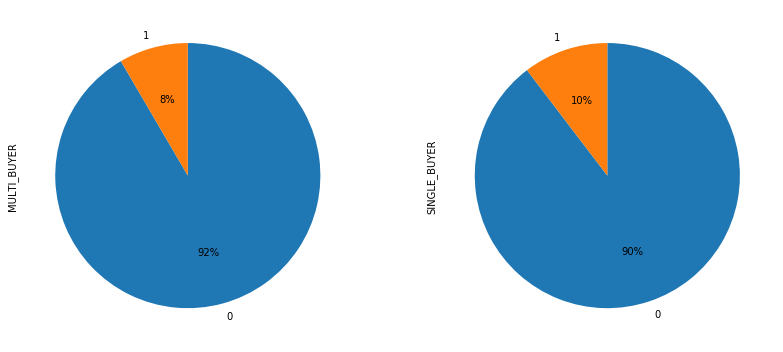

In [14]:
customers_df.groupby(['CUSTOMER_GROUP'])['ONLINE_PURCHASE'].value_counts().unstack().plot.bar(figsize = [12, 5], rot=0).set_title('CUSTOMER_GROUP vs. ONLINE_PURCHASE')

customers_df.groupby(['CUSTOMER_GROUP'])['ONLINE_PURCHASE'].value_counts().unstack().T.plot.pie(subplots=True, autopct='%1.f%%', figsize=[12,5], legend=False, startangle = 90, counterclock = False)

plt.tight_layout()
plt.show()

### Data Exploration - Attributes vs. Values

#### Load attributes dataset

In [15]:
# attributes dataset
attributes_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, index_col=[1]).reset_index()
del attributes_df['Unnamed: 0']
attributes_df.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [16]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
Information level    312 non-null object
Attribute            313 non-null object
Description          313 non-null object
Additional notes     20 non-null object
dtypes: object(4)
memory usage: 9.9+ KB


#### Load values dataset

In [17]:
# values dataset
values_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, index_col=[1,2]).reset_index()
del values_df['Unnamed: 0']
values_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [18]:
values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
Attribute      2258 non-null object
Description    2258 non-null object
Value          2258 non-null object
Meaning        2247 non-null object
dtypes: object(4)
memory usage: 70.6+ KB


In [19]:
values_df.Attribute.unique().size

314

In [20]:
attributes_df.Attribute.unique().size

313

In [21]:
# values_df only
np.setdiff1d(values_df.Attribute.unique(), attributes_df.Attribute)

array(['BIP_FLAG', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_LOTTO_RZ',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'KBA13_CCM_3000', 'KBA13_CCM_3001'], dtype=object)

In [22]:
# attributes_df only
np.setdiff1d(attributes_df.Attribute, values_df.Attribute.unique())

array(['ARBEIT', 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
       'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
       'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
       'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
       'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
      dtype=object)

From above, we can find attributes dataset features not normalized. We will use values dataset to query data, and merge attributes dataset feature to values.

Create `attr_only_attributes_not_values` to hold features only in `attributes_df` and not in `values_df`.

In [23]:
attr_only_attributes_not_values = np.array(['ARBEIT', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'])
attr_only_attributes_not_values

array(['ARBEIT', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
      dtype='<U23')

In [24]:
np.intersect1d(values_df.Attribute.unique().tolist(), attributes_df.Attribute).shape

(300,)

creqte `annot_attribute` as combined features from `vlaues_df` and `attributes_df`.

In [25]:
annot_attribute = np.union1d(values_df.Attribute.unique(), attr_only_attributes_not_values)
annot_attribute.shape

(322,)

We found `only_attr_customers` not in `annot_attribute`

In [26]:
np.isin(only_attr_customers, values_df.Attribute)

array([False, False, False])

#### Analyze feature type

Fina all value of `values_df`

In [27]:
values_df.Value.unique()

array([-1, 0, 1, 2, 3, '-1, 0', 4, 9, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, '…', '1A', '1B', '1C', '1D', '1E', '2A',
       '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D',
       '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D',
       '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D',
       '9A', '9B', '9C', '9D', '9E', 22, 23, 24, 25, 31, 32, 33, 34, 35,
       41, 42, 43, 44, 45, 51, 52, 53, 54, 55, '-1, 9', 26, 27, 28, 29,
       30, 36, 37, 38, 39, 40, '-1', 'O', 'W'], dtype=object)

In [28]:
values_df.Value.value_counts()

1        304
2        300
3        296
4        274
5        257
0        198
-1       138
6        101
7         83
-1, 9     75
8         31
9         30
10        24
-1, 0     16
11         8
…          7
12         6
14         4
13         4
15         4
21         3
18         2
34         2
22         2
23         2
25         2
19         2
35         2
20         2
17         2
        ... 
8C         1
26         1
6D         1
3B         1
9E         1
5F         1
5D         1
6C         1
8D         1
5A         1
8B         1
52         1
53         1
27         1
55         1
1B         1
1C         1
6F         1
1D         1
36         1
8A         1
3C         1
W          1
7B         1
1E         1
4C         1
7E         1
-1         1
9D         1
54         1
Name: Value, Length: 102, dtype: int64

In [29]:
values_df.groupby(['Attribute'])['Value'].count().unique()

array([ 5,  6, 22,  3,  1,  8, 10, 26, 44,  7, 11,  9, 12,  2,  4, 40, 16])

In [30]:
values_df.groupby(['Attribute'])['Value'].unique().values

array([array([-1, 0, 1, 2, 3], dtype=object),
       array(['-1, 0', 1, 2, 3, 4, 9], dtype=object),
       array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21], dtype=object),
       array(['-1, 0', 1, 2], dtype=object), array(['…'], dtype=object),
       array(['…'], dtype=object), array(['…'], dtype=object),
       array(['…'], dtype=object),
       array([-1, 1, 2, 3, 4, 5, 6, 7], dtype=object),
       array([-1, 0, 1], dtype=object),
       array([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object),
       array([-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41,
       42, 43, 44, 45, 51, 52, 53, 54, 55], dtype=object),
       array(['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B',
       '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D',
       '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C',
       '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E'],
      dtype=objec

##### Quantitative Attribute

create `num_annot_attribute` to hold numeric features

In [31]:
num_annot_attribute = values_df.Attribute.unique()[np.where(values_df.groupby(['Attribute'], sort=False)['Value'].count() == 1)]
num_annot_attribute

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'],
      dtype=object)

In [32]:
values_df.loc[np.where(values_df.Attribute.isin(num_annot_attribute))]

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,…,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,…,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,…,numeric value


##### Categorical Attribute

create `bin_cat_annot_attribute` to hold binary category features

In [33]:
values_df.Attribute.unique()[np.where(values_df.groupby(['Attribute'], sort=False)['Value'].count() == 2)]

array(['GREEN_AVANTGARDE'], dtype=object)

In [34]:
bin_cat_annot_attribute = np.array(values_df.Attribute.unique()[np.where(values_df.groupby(['Attribute'])['Value'].count() == 2)])
bin_cat_annot_attribute

array(['GREEN_AVANTGARDE'], dtype=object)

In [35]:
values_df.loc[np.where(values_df.Attribute.isin(bin_cat_annot_attribute))]

,Attribute,Description,Value,Meaning
732,GREEN_AVANTGARDE,Green avantgarde,0,doesn't belong to the green avantgarde
733,GREEN_AVANTGARDE,the environmental sustainability is the domina...,1,belongs to the green avantgarde


create `str_cat_annot_attribute` to hold string category features

In [36]:
values_df.loc[np.where(values_df.Value.str.contains("O|W") == True)]

,Attribute,Description,Value,Meaning
2014,OST_WEST_KZ,flag indicating the former GDR/FRG,O,East (GDR)
2015,OST_WEST_KZ,flag indicating the former GDR/FRG,W,West (FRG)


In [37]:
values_df[values_df.Attribute == 'OST_WEST_KZ']

,Attribute,Description,Value,Meaning
2013,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown
2014,OST_WEST_KZ,flag indicating the former GDR/FRG,O,East (GDR)
2015,OST_WEST_KZ,flag indicating the former GDR/FRG,W,West (FRG)


In [38]:
str_cat_annot_attribute = np.array(['OST_WEST_KZ'])
str_cat_annot_attribute

array(['OST_WEST_KZ'], dtype='<U11')

In [39]:
values_df[values_df.Attribute == 'CAMEO_DEU_2015']

,Attribute,Description,Value,Meaning
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
62,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1B,Wealthy Best Ager
63,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1C,Successful Songwriter
64,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1D,Old Nobility
65,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1E,City Nobility
66,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2A,Cottage Chic
67,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2B,Noble Jogger
68,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2C,Established gourmet
69,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2D,Fine Management
70,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,3A,Career & Family


In [40]:
str_cat_annot_attribute = np.union1d(str_cat_annot_attribute, ['CAMEO_DEU_2015'])
str_cat_annot_attribute

array(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='<U14')

create `num_cat_annot_attribute` to hold numerical category features

In [41]:
_ = np.setdiff1d(values_df.Attribute, bin_cat_annot_attribute)
_ = np.setdiff1d(_, str_cat_annot_attribute)
_ = np.setdiff1d(_, num_annot_attribute)
num_cat_annot_attribute = values_df.loc[np.where(values_df.Attribute.isin(_))[0]].groupby(['Attribute'])['Value'].unique().index.values
num_cat_annot_attribute

array(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ',
       'BALLRAUM', 'BIP_FLAG', 'CAMEO_DEUG_2015', 'CAMEO_DEUINTL_2015',
       'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ',
       'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ',
       'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ',
       'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ',
       'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK_RZ',
       'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KK_KUNDENTYP',
       'D19_KONSUMTYP', 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ',
       'D19_LOTTO_RZ

In [42]:
values_df[values_df.Attribute.isin(num_cat_annot_attribute)]['Value'].unique()

array([-1, 0, 1, 2, 3, '-1, 0', 4, 9, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42,
       43, 44, 45, 51, 52, 53, 54, 55, '-1, 9', 26, 27, 28, 29, 30, 36,
       37, 38, 39, 40, '-1'], dtype=object)

In [43]:
assert values_df.Attribute.unique().size == num_annot_attribute.size + bin_cat_annot_attribute.size + str_cat_annot_attribute.size + num_cat_annot_attribute.size

In [44]:
attributes_df[attributes_df.Attribute.isin(attr_only_attributes_not_values)]

,Information level,Attribute,Description,Additional notes
67,Household,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segm...,NaN
68,Household,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segm...,NaN
69,Household,D19_VERSI_DATUM,actuality of the last transaction for the segm...,NaN
188,Postcode,PLZ,postcode,NaN
300,PLZ8,PLZ8,sub-postcode (about 8 PLZ8 make up one PLZ) an...,NaN
308,Community,ARBEIT,share of unemployed person in the community,NaN
309,Community,EINWOHNER,inhabitants,NaN
310,Community,GKZ,standardized community-code,NaN


In [45]:
num_cat_annot_attribute = np.union1d(num_cat_annot_attribute, ['D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM'])
num_cat_annot_attribute.shape

(307,)

In [46]:
num_annot_attribute = np.union1d(num_annot_attribute, ['ARBEIT'])
num_annot_attribute.shape

(8,)

In [47]:
unused_annot_attribute = np.array(['PLZ', 'PLZ8', 'EINWOHNER', 'GKZ'])
unused_annot_attribute.shape

(4,)

In [48]:
assert annot_attribute.size == num_annot_attribute.size + bin_cat_annot_attribute.size + str_cat_annot_attribute.size + num_cat_annot_attribute.size + unused_annot_attribute.size

create `customers_bin_cat_not_annot_attribute` to hold binary category features not in `attributes_df` and `values_df`.

In [49]:
customers_bin_cat_not_annot_attribute = np.array('ONLINE_PURCHASE')
customers_bin_cat_not_annot_attribute

array('ONLINE_PURCHASE', dtype='<U15')

create `customers_str_cat_not_annot_attribute` to hold string category features  not in `attributes_df` and `values_df`.

In [50]:
customers_str_cat_not_annot_attribute = np.array(['CUSTOMER_GROUP', 'PRODUCT_GROUP'])
customers_str_cat_not_annot_attribute

array(['CUSTOMER_GROUP', 'PRODUCT_GROUP'], dtype='<U14')

In [51]:
assert only_attr_customers.size == customers_bin_cat_not_annot_attribute.size + customers_str_cat_not_annot_attribute.size

### Data Exploration - customers vs. values

check `annot_attribute` existence of `customers_df`

In [52]:
np.intersect1d(customers_df.columns, annot_attribute).shape

(276,)

create `annot_attr_customers_values` to hold common features of `customer_df` and `annot_attribute`

In [53]:
annot_attr_customers_values = np.intersect1d(customers_df.columns.values, annot_attribute)
annot_attr_customers_values.shape

(276,)

In [54]:
not_annot_attr_customers_values = np.setdiff1d(customers_df.columns.values, annot_attr_customers_values)
not_annot_attr_customers_values.shape

(93,)

In [55]:
customers_df[annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 276 entries, AGER_TYP to ZABEOTYP
dtypes: float64(216), int64(57), object(3)
memory usage: 403.6+ MB


#### Check `bin_cat_annot_attribute`

create `customers_bin_cat_annot_attribute` to hold `bin_cat_annot_attribute` in `customers_df`

In [56]:
customers_bin_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, bin_cat_annot_attribute)
customers_bin_cat_annot_attribute

array(['GREEN_AVANTGARDE'], dtype=object)

In [57]:
for col in customers_bin_cat_annot_attribute:
    v1 = customers_df[col].unique()
    v2 = values_df[values_df.Attribute == col]['Value'].values
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has un-documented value: {}'.format(col, v))

#### Check `str_cat_annot_attribute`

create `customers_str_cat_annot_attribute` to hold `str_cat_annot_attribute` in `customers_df`

In [58]:
customers_str_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, str_cat_annot_attribute)
customers_str_cat_annot_attribute

array(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype=object)

In [59]:
for col in customers_str_cat_annot_attribute:
    v1 = customers_df[col].unique()[~pd.isnull(customers_df[col].unique())]
    v2 = values_df[values_df.Attribute == col]['Value'].values.astype(str)
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has un-documented value: {}'.format(col, v))

CAMEO_DEU_2015 feature has un-documented value: ['XX']


#### Check `num_cat_annot_attribute`

create `customers_num_cat_annot_attribute` to hold `num_cat_annot_attribute` in `customers_df`

In [60]:
customers_num_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, num_cat_annot_attribute)
customers_num_cat_annot_attribute.size

265

In [61]:
for col in customers_num_cat_annot_attribute:
    
    unknown_v = []
    v1 = customers_df[col].dropna().apply(lambda x: unknown_v.append(x) if isinstance(x, str) else x).dropna().unique()
    
    # assue value of 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM' are as same as 'D19_BANKEN_DATUM'
    if col in ['D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM']:
        col = 'D19_BANKEN_DATUM'
        
    v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
    
    v = np.setdiff1d(v1, v2)
    unknown_v = np.unique(np.array(unknown_v))
    
    if len(unknown_v) > 0:
        print('{} feature has unknown value: {}'.format(col, unknown_v))
    if v.size > 0:
        print('{} feature has un-documented value: {}'.format(col, v))

CAMEO_DEUG_2015 feature has unknown value: ['1' '2' '3' '4' '5' '6' '7' '8' '9' 'X']
KBA05_MODTEMP feature has un-documented value: [6.]
LP_FAMILIE_FEIN feature has un-documented value: [0.]
LP_FAMILIE_GROB feature has un-documented value: [0.]
LP_LEBENSPHASE_FEIN feature has un-documented value: [0.]
LP_LEBENSPHASE_GROB feature has un-documented value: [0.]


In [62]:
values_df[values_df.Attribute == 'KBA05_MODTEMP']

,Attribute,Description,Value,Meaning
1025,KBA05_MODTEMP,development of the most common car segment in ...,"-1, 9",unknown
1026,KBA05_MODTEMP,development of the most common car segment in ...,1,promoted
1027,KBA05_MODTEMP,development of the most common car segment in ...,2,stayed upper level
1028,KBA05_MODTEMP,development of the most common car segment in ...,3,stayed lower/average level
1029,KBA05_MODTEMP,development of the most common car segment in ...,4,demoted
1030,KBA05_MODTEMP,development of the most common car segment in ...,5,new building


In [63]:
values_df[values_df.Attribute == 'LP_FAMILIE_FEIN']

,Attribute,Description,Value,Meaning
1892,LP_FAMILIE_FEIN,familytyp fine,1,single
1893,LP_FAMILIE_FEIN,familytyp fine,2,couple
1894,LP_FAMILIE_FEIN,familytyp fine,3,young single parent
1895,LP_FAMILIE_FEIN,familytyp fine,4,single parent with teenager
1896,LP_FAMILIE_FEIN,familytyp fine,5,single parent with child of full age
1897,LP_FAMILIE_FEIN,familytyp fine,6,young family
1898,LP_FAMILIE_FEIN,familytyp fine,7,family with teenager
1899,LP_FAMILIE_FEIN,familytyp fine,8,family with child of full age
1900,LP_FAMILIE_FEIN,familytyp fine,9,shared flat
1901,LP_FAMILIE_FEIN,familytyp fine,10,two-generational household


In [64]:
values_df[values_df.Attribute == 'LP_FAMILIE_GROB']

,Attribute,Description,Value,Meaning
1903,LP_FAMILIE_GROB,familytyp rough,1,single
1904,LP_FAMILIE_GROB,familytyp rough,2,couple
1905,LP_FAMILIE_GROB,familytyp rough,3,single parent
1906,LP_FAMILIE_GROB,familytyp rough,4,NaN
1907,LP_FAMILIE_GROB,familytyp rough,5,NaN
1908,LP_FAMILIE_GROB,familytyp rough,6,family
1909,LP_FAMILIE_GROB,familytyp rough,7,NaN
1910,LP_FAMILIE_GROB,familytyp rough,8,NaN
1911,LP_FAMILIE_GROB,familytyp rough,9,multiperson household
1912,LP_FAMILIE_GROB,familytyp rough,10,NaN


In [65]:
values_df[values_df.Attribute == 'LP_LEBENSPHASE_FEIN']

,Attribute,Description,Value,Meaning
1914,LP_LEBENSPHASE_FEIN,lifestage fine,1,single low-income earners of younger age
1915,LP_LEBENSPHASE_FEIN,lifestage fine,2,single low-income earners of middle age
1916,LP_LEBENSPHASE_FEIN,lifestage fine,3,single average earners of younger age
1917,LP_LEBENSPHASE_FEIN,lifestage fine,4,single average earners of middle age
1918,LP_LEBENSPHASE_FEIN,lifestage fine,5,single low-income earners of advanced age
1919,LP_LEBENSPHASE_FEIN,lifestage fine,6,single low-income earners at retirement age
1920,LP_LEBENSPHASE_FEIN,lifestage fine,7,single average earners of advanced age
1921,LP_LEBENSPHASE_FEIN,lifestage fine,8,single average earners at retirement age
1922,LP_LEBENSPHASE_FEIN,lifestage fine,9,single independant persons
1923,LP_LEBENSPHASE_FEIN,lifestage fine,10,wealthy single homeowners


In [66]:
values_df[values_df.Attribute == 'LP_LEBENSPHASE_GROB']

,Attribute,Description,Value,Meaning
1954,LP_LEBENSPHASE_GROB,lifestage rough,1,single low-income- and average earners of youn...
1955,LP_LEBENSPHASE_GROB,lifestage rough,2,single low-income- and average earners of high...
1956,LP_LEBENSPHASE_GROB,lifestage rough,3,single high-income earners
1957,LP_LEBENSPHASE_GROB,lifestage rough,4,single low-income- and average earner-couples
1958,LP_LEBENSPHASE_GROB,lifestage rough,5,single high-income earner-couples
1959,LP_LEBENSPHASE_GROB,lifestage rough,6,single parents
1960,LP_LEBENSPHASE_GROB,lifestage rough,7,single low-income- and average earner-families
1961,LP_LEBENSPHASE_GROB,lifestage rough,8,high-income earner-families
1962,LP_LEBENSPHASE_GROB,lifestage rough,9,average earners of younger age from mulitperso...
1963,LP_LEBENSPHASE_GROB,lifestage rough,10,low-income- and average earners of higher age ...


#### Check `num_annot_attribute`

create `customers_num_annot_attribute` to hold `num_annot_attribute` in `customers_df`

In [67]:
customers_num_annot_attribute = np.intersect1d(annot_attr_customers_values, num_annot_attribute)
customers_num_annot_attribute

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'ARBEIT', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'],
      dtype=object)

In [68]:
for col in customers_num_annot_attribute:
    if not np.issubdtype(customers_df[col].dtype, np.number):
        print('{} is not numberic type'.format(col))

#### To fix the error, we will need to ...

1. CAMEO_DEU_2015: **change 'XX' to NA**
1. CAMEO_DEUG_2015: **change '1', '2', '3', '4', '5', '6', '7', '8', '9' to integer, and 'X' to NA**
1. KBA05_MODTEMP: **change 6 to 1 for unknown**
1. LP_FAMILIE_FEIN: **chagne 0 to NA**
1. LP_FAMILIE_GROB: **chagne 0 to NA**
1. LP_LEBENSPHASE_FEIN: **chagne 0 to NA**
1. LP_LEBENSPHASE_GROB: **chagne 0 to NA**

In [69]:
assert annot_attr_customers_values.size == customers_bin_cat_annot_attribute.size + customers_str_cat_annot_attribute.size + customers_num_cat_annot_attribute.size + customers_num_annot_attribute.size

#### check `not_annot_attr_customers_values`

In [70]:
customers_df[not_annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 93 columns):
AKT_DAT_KL                    145056 non-null float64
ALTERSKATEGORIE_FEIN          139810 non-null float64
ALTER_KIND1                   11766 non-null float64
ALTER_KIND2                   5100 non-null float64
ALTER_KIND3                   1275 non-null float64
ALTER_KIND4                   236 non-null float64
ANZ_KINDER                    145056 non-null float64
ANZ_STATISTISCHE_HAUSHALTE    141725 non-null float64
CAMEO_INTL_2015               141224 non-null object
CJT_KATALOGNUTZER             188439 non-null float64
CJT_TYP_1                     188439 non-null float64
CJT_TYP_2                     188439 non-null float64
CJT_TYP_3                     188439 non-null float64
CJT_TYP_4                     188439 non-null float64
CJT_TYP_5                     188439 non-null float64
CJT_TYP_6                     188439 non-null float64
CUSTOMER_GROUP                1916

In [71]:
customers_df[not_annot_attr_customers_values].isnull().mean().value_counts().sort_index(ascending=False)

0.998769     1
0.993347     1
0.973389     1
0.938607     1
0.584064     1
0.444989     1
0.283117     1
0.280415     1
0.270501     1
0.267574     9
0.263373     3
0.263227     2
0.263123     1
0.260509     6
0.249781     3
0.248873     5
0.243128     6
0.230585     1
0.016765     9
0.000000    39
dtype: int64

#### Check null value

create `customers_unused_not_annot_attribute` to hold droped attribute from `not_annot_attr_customers_values`

CROP CRITERIA: __null value > 30%__

In [72]:
customers_unused_not_annot_attribute = not_annot_attr_customers_values[customers_df[not_annot_attr_customers_values].isnull().mean() > .3]
customers_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'KK_KUNDENTYP'], dtype=object)

In [73]:
customers_df[not_annot_attr_customers_values].isnull().sum()

AKT_DAT_KL                     46596
ALTERSKATEGORIE_FEIN           51842
ALTER_KIND1                   179886
ALTER_KIND2                   186552
ALTER_KIND3                   190377
ALTER_KIND4                   191416
ANZ_KINDER                     46596
ANZ_STATISTISCHE_HAUSHALTE     49927
CAMEO_INTL_2015                50428
CJT_KATALOGNUTZER               3213
CJT_TYP_1                       3213
CJT_TYP_2                       3213
CJT_TYP_3                       3213
CJT_TYP_4                       3213
CJT_TYP_5                       3213
CJT_TYP_6                       3213
CUSTOMER_GROUP                     0
D19_BANKEN_DIREKT                  0
D19_BANKEN_GROSS                   0
D19_BANKEN_LOKAL                   0
D19_BANKEN_REST                    0
D19_BEKLEIDUNG_GEH                 0
D19_BEKLEIDUNG_REST                0
D19_BILDUNG                        0
D19_BIO_OEKO                       0
D19_BUCH_CD                        0
D19_DIGIT_SERV                     0
D

In [74]:
for col in customers_df[not_annot_attr_customers_values].select_dtypes(include=['object']).columns:
    print('column: {}'.format(col))
    print(customers_df[col].unique())

column: CAMEO_INTL_2015
[13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']
column: CUSTOMER_GROUP
['MULTI_BUYER' 'SINGLE_BUYER']
column: D19_LETZTER_KAUF_BRANCHE
['D19_UNBEKANNT' 'D19_BANKEN_GROSS' 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE'
 'D19_BUCH_CD' 'D19_DROGERIEARTIKEL' 'D19_SONSTIGE' 'D19_TECHNIK'
 'D19_VERSICHERUNGEN' 'D19_TELKO_MOBILE' 'D19_VOLLSORTIMENT' nan
 'D19_HAUS_DEKO' 'D19_ENERGIE' 'D19_REISEN' 'D19_BANKEN_LOKAL'
 'D19_VERSAND_REST' 'D19_BEKLEIDUNG_REST' 'D19_FREIZEIT'
 'D19_BEKLEIDUNG_GEH' 'D19_TELKO_REST' 'D19_SAMMELARTIKEL'
 'D19_BANKEN_DIREKT' 'D19_KINDERARTIKEL' 'D19_BANKEN_REST'
 'D19_LEBENSMITTEL' 'D19_GARTEN' 'D19_HANDWERK' 'D19_RATGEBER'
 'D19_DIGIT_SERV' 'D19_BIO_OEKO' 'D19_BILDUNG' 'D19_WEIN_FEINKOST'
 'D19_TIERARTIKEL' 'D19_LOTTO' 'D19_KOSMETIK']
column: EINGEFUEGT_AM
['1992-02-12 00:00:00' 

Ananlyze EINGEFUEGT_AM

In [75]:
(pd.to_datetime(customers_df['EINGEFUEGT_AM']).astype(int)/ 10**9).head()

0    6.978528e+08
1   -9.223372e+09
2    6.976800e+08
3    6.976800e+08
4    6.978528e+08
Name: EINGEFUEGT_AM, dtype: float64

create `customers_num_not_annot_attribute` to hold numeric attribute from `not_annot_attr_customers_values`

In [76]:
customers_num_not_annot_attribute = np.array(['EINGEFUEGT_AM'])

In [77]:
_ = (pd.to_datetime(customers_df['EINGEFUEGT_AM']).astype(int)/ 10**9).head()

if not np.issubdtype(_.dtype, np.number):
    print('{} is not numberic type'.format(EINGEFUEGT_AM))

#### Analyze D19_LETZTER_KAUF_BRANCH

In [78]:
np.setdiff1d(customers_df['D19_LETZTER_KAUF_BRANCHE'].dropna().unique(), customers_df.columns)

array(['D19_UNBEKANNT'], dtype=object)

In [79]:
customers_df['D19_LETZTER_KAUF_BRANCHE'].apply(lambda x: np.where(np.isin(customers_df.columns, x))[0][0] if np.where(np.isin(customers_df.columns, x))[0].size > 0 else -1).value_counts()

-1     79607
 68    14540
 93    10534
 42    10038
 94     8647
 55     8129
 67     6317
 38     5975
 44     5528
 45     4454
 39     4096
 86     3619
 31     3466
 60     3053
 78     2303
 63     2253
 74     2131
 70     1836
 32     1684
 46     1672
 66     1610
 64     1519
 56     1439
 95     1424
 37     1233
 41      808
 65      666
 43      653
 47      568
 54      532
 40      357
 79      345
 33      306
 62      194
 59      116
Name: D19_LETZTER_KAUF_BRANCHE, dtype: int64

create `customers_num_cat_not_annot_attribute` to hold numeric categorical attribute from `not_annot_attr_customers_values`

In [80]:
customers_num_cat_not_annot_attribute = np.array(['D19_LETZTER_KAUF_BRANCH'])
customers_num_cat_not_annot_attribute

array(['D19_LETZTER_KAUF_BRANCH'], dtype='<U23')

In [81]:
_ = customers_df['D19_LETZTER_KAUF_BRANCHE'].apply(lambda x: np.where(np.isin(customers_df.columns, x))[0][0] if np.where(np.isin(customers_df.columns, x))[0].size > 0 else -1)

if not np.issubdtype(_.dtype, np.number):
    print('{} is not numberic type'.format(D19_LETZTER_KAUF_BRANCHE))

#### Analyze CAMEO_INTL_2015

In [82]:
customers_df['CAMEO_INTL_2015'].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

In [83]:
int_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: int_v.append(x) if isinstance(x, int) else x).dropna().unique()

float_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: float_v.append(x) if isinstance(x, float) else x).dropna().unique()

str_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: str_v.append(x) if isinstance(x, str) else x).dropna().unique()

int_v = np.unique(np.array(int_v))
float_v = np.unique(np.array(float_v))
str_v = np.unique(np.array(str_v))

if len(int_v) > 0:
    print('CAMEO_INTL_2015 feature has int value: {}'.format(int_v))
if len(float_v) > 0:
    print('CAMEO_INTL_2015 feature has float value: {}'.format(float_v))
if len(str_v) > 0:
    print('CAMEO_INTL_2015 feature has string value: {}'.format(str_v))

CAMEO_INTL_2015 feature has float value: [12. 13. 14. 15. 22. 23. 24. 25. 31. 32. 33. 34. 35. 41. 43. 44. 45. 51.
 52. 54. 55.]
CAMEO_INTL_2015 feature has string value: ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55' 'XX']


In [84]:
customers_num_cat_not_annot_attribute = np.union1d(customers_num_cat_not_annot_attribute, ['CAMEO_INTL_2015'])
customers_num_cat_not_annot_attribute

array(['CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCH'], dtype='<U23')

#### Analyze int64 dtype values

In [85]:
for col in customers_df[not_annot_attr_customers_values].select_dtypes(include=['int64']).columns:
    print('column: {}'.format(col))
    print(customers_df[col].unique())

column: D19_BANKEN_DIREKT
[0 5 7 3 6 1 4 2]
column: D19_BANKEN_GROSS
[0 5 3 6 4 2 1]
column: D19_BANKEN_LOKAL
[0 3 7 6 5 2 1 4]
column: D19_BANKEN_REST
[0 6 5 3 7 2 4 1]
column: D19_BEKLEIDUNG_GEH
[0 6 5 2 3 4 7 1]
column: D19_BEKLEIDUNG_REST
[0 6 7 3 5 1 2 4]
column: D19_BILDUNG
[0 6 7 2 5 4 3 1]
column: D19_BIO_OEKO
[0 2 7 3 6 5 4 1]
column: D19_BUCH_CD
[6 0 2 5 3 1 7 4]
column: D19_DIGIT_SERV
[0 5 6 3 2 7 1 4]
column: D19_DROGERIEARTIKEL
[0 6 4 3 7 5 2 1]
column: D19_ENERGIE
[0 5 3 6 7 2 4 1]
column: D19_FREIZEIT
[0 6 3 7 5 2 1 4]
column: D19_GARTEN
[0 6 7 3 5 1 2 4]
column: D19_HANDWERK
[0 6 7 5 3 2 4 1]
column: D19_HAUS_DEKO
[6 0 3 2 5 7 4 1]
column: D19_KINDERARTIKEL
[0 2 6 3 7 5 1 4]
column: D19_KONSUMTYP_MAX
[2 3 4 1 8 9]
column: D19_KOSMETIK
[0 7 6 3 4 5 2 1]
column: D19_LEBENSMITTEL
[6 0 5 2 3 7 4 1]
column: D19_NAHRUNGSERGAENZUNG
[0 5 3 6 7 4 2 1]
column: D19_RATGEBER
[0 6 5 2 7 3 4 1]
column: D19_REISEN
[0 6 7 5 3 2 1 4]
column: D19_SAMMELARTIKEL
[6 0 2 5 3 7 4 1]
column: D

In [86]:
customers_num_cat_not_annot_attribute = np.union1d(customers_num_cat_not_annot_attribute, customers_df[not_annot_attr_customers_values].select_dtypes(include=['int64']).columns)
customers_num_cat_not_annot_attribute.shape

(39,)

In [87]:
for col in customers_df[not_annot_attr_customers_values].select_dtypes(include=['float64']).columns:
    print('column: {}'.format(col))
    _ = customers_df[col].dropna().unique()
    print(_)
    if (_.size == 2):
        customers_bin_cat_not_annot_attribute = np.union1d(customers_bin_cat_not_annot_attribute, col)
    elif (_.size < 15):
        customers_num_cat_not_annot_attribute = np.union1d(customers_num_cat_not_annot_attribute, col)
    elif (_.size >= 15):
        customers_num_not_annot_attribute = np.union1d(customers_num_not_annot_attribute, col)

column: AKT_DAT_KL
[1. 9. 3. 7. 5. 2. 4. 6. 8.]
column: ALTERSKATEGORIE_FEIN
[10.  0.  8. 14.  9.  4. 13.  6. 12. 19. 17. 15. 11. 16.  7. 18. 21. 25.
 20. 24.  5.  2. 22.  3. 23.]
column: ALTER_KIND1
[ 8. 12.  9.  7. 13. 17. 14. 18. 11. 16.  6. 10. 15.  5.  3.  4.  2.]
column: ALTER_KIND2
[ 9. 17. 10. 14. 13. 12. 11. 16. 18. 15.  7.  5.  8.  6.  3.  2.  4.]
column: ALTER_KIND3
[13. 16. 18. 15. 17. 14. 12. 11. 10.  8.  7.  9.  6.  5.]
column: ALTER_KIND4
[18. 12. 16. 13. 17. 11. 14. 15. 10.  8.]
column: ANZ_KINDER
[0. 1. 3. 2. 4. 5. 6. 8. 7.]
column: ANZ_STATISTISCHE_HAUSHALTE
[  1.   7.  82.   9.  17.   8.  25.   3.  41.   2.  10.  13.  14.  47.
   0.   6.   4.  97.  12.   5.  20.  23.  39.  49.  51.  18.  16.  11.
  15.  57.  35.  19.  26.  36. 339.  21.  48.  22.  34.  46.  32.  52.
  27. 309.  93.  87.  29.  61.  30.  33.  40.  42.  28. 135.  37.  84.
  43.  72.  90.  45.  81. 256.  79. 230. 111.  53.  31. 354.  38.  77.
 152.  59.  44.  73.  98.  67.  71.  88.  54.  74. 252.  68. 1

In [88]:
customers_bin_cat_not_annot_attribute

array(['DSL_FLAG', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'ONLINE_PURCHASE',
       'SOHO_KZ', 'UNGLEICHENN_FLAG'], dtype='<U16')

In [89]:
customers_num_cat_not_annot_attribute

array(['AKT_DAT_KL', 'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
       'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
       'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_LETZTER_KAUF_BRANCH', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D19_VERSAND_REST', 'D19_VERSICHERUNGEN',
       'D19_VERSI_ONLINE_QUOTE_12', 'D19_VOLLSORTIME

In [90]:
customers_num_not_annot_attribute

array(['ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
       'ANZ_STATISTISCHE_HAUSHALTE', 'EINGEFUEGT_AM',
       'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'VERDICHTUNGSRAUM'],
      dtype='<U26')

#### To fix the error, we will need to ...

1. ALTER_KIND1, ALTER_KIND2, ALTER_KIND3, ALTER_KIND4, EXTSEL992, KK_KUNDENTYP: **drop (null value > 30%)**
1. EINGEFUEGT_AM: **convert datetime string to number of seconds to the unix epoch start**
1. CAMEO_INTL_2015: **change '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33' to integer, and 'XX' to NA**
1. D19_LETZTER_KAUF_BRANCH: **change column string to column intex**

In [91]:
not_annot_attr_customers_values.size

93

In [92]:
customers_num_not_annot_attribute.size

8

In [93]:
customers_bin_cat_not_annot_attribute.size

6

In [94]:
customers_num_cat_not_annot_attribute.size

78

In [95]:
customers_str_cat_not_annot_attribute.size

2

In [96]:
customers_unused_not_annot_attribute.size

6

In [97]:
assert not_annot_attr_customers_values.size == customers_bin_cat_not_annot_attribute.size + customers_str_cat_not_annot_attribute.size + customers_num_cat_not_annot_attribute.size + customers_num_not_annot_attribute.size + customers_unused_not_annot_attribute.size

AssertionError: 

### Data Preprocessing

In [ ]:
def preprocessing(df=df):
    
    

In [ ]:
pre_processing(customers_df)

#### Analyze null value of `annot_attr_customers_values`

In [ ]:
customers_df[annot_attr_customers_values].isnull().mean().value_counts()

Case1: 51281 customer all have 107 null value

In [ ]:
customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 51281).values)[0]]

In [ ]:
attributes_df.loc[np.where(attributes_df.Attribute.isin(customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 51281).values)[0]]))]

In [ ]:
attributes_df[attributes_df.Attribute == 'PLZ8'].Description.tolist()

In [ ]:
PLZ8_info_attributes = attributes_df[attributes_df['Information level'] == 'PLZ8']['Attribute'].values
PLZ8_info_attributes.shape

In [ ]:
np.setdiff1d(PLZ8_info_attributes, customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 51281).values)[0]].values)

In [ ]:
np.intersect1d(PLZ8_info_attributes, customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 51281).values)[0]].values).shape

In [ ]:
customers_df[np.intersect1d(PLZ8_info_attributes, customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 51281).values)[0]].values)].isnull().sum().value_counts()

In [ ]:
customers_df[np.intersect1d(PLZ8_info_attributes, customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 51281).values)[0]].values)].isnull().sum().value_counts().index[0]/customers_df.shape[0]

In [ ]:
customers.columns.isin(PLZ8_info_attributes)

In [ ]:
values_df[values_df.Attribute == 'KBA13_ANZAHL_PKW']

In [ ]:
values_df[values_df.Meaning.str.find('num') >= 0]

In [ ]:
customers_df[np.setdiff1d(np.intersect1d(PLZ8_info_attributes, customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 51281).values)[0]].values), num_attr)].apply(pd.value_counts).isnull().sum().value_counts()

Case 2: 55980 customer all have 64 null value

In [ ]:
customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 55980).values)[0]]

In [ ]:
attributes_df.loc[np.where(attributes_df.Attribute.isin(customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 55980).values)[0]]))]

In [ ]:
attributes_df['Information level'].value_counts()

In [ ]:
attributes_df[attributes_df['Information level'].str.find('Microcell') >= 0]

In [ ]:
np.setdiff1d(attributes_df[attributes_df['Information level'].str.find('Microcell') >= 0].Attribute.values, customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 55980).values)[0]].values)

In [ ]:
np.intersect1d(attributes_df[attributes_df['Information level'].str.find('Microcell') >= 0].Attribute.values, customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 55980).values)[0]].values).shape

In [ ]:
attributes_df[attributes_df.Attribute.isin(np.setdiff1d(attributes_df[attributes_df['Information level'].str.find('Microcell') >= 0].Attribute.values, customers_df[annot_attr_customers_values].columns[np.where((customers_df[annot_attr_customers_values].isnull().sum() == 55980).values)[0]].values))]

In [ ]:
n_match_val_annot_attr_customers_values = 0
for col in annot_attr_customers_values:
    if (customers_df[col].isin(values_df[values_df['Attribute'] == col]['Value'].values).count() == customers_df.shape[0]):
        n_match_val_annot_attr_customers_values += 1
print(n_match_val_annot_attr_customers_values)

In [ ]:
customers_df[annot_attr_customers_values].select_dtypes(include='int64').describe(include='all')

In [ ]:
text_field = np.array(['OST_WEST_KZ', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'])

In [ ]:
time_field = 

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
values_customers_df = customers_df[annot_attr_customers_values_2017]
values_customers_df.info()

In [ ]:
customers_df[not_attr_customers_values_2017.tolist()].info()

In [ ]:
values_customers_df.isna().mean().value_counts()

In [ ]:
for col in values_customers_df.columns:
    values_customers_df[col].fillna(values_customers_df[col].median,inplace=True)

In [ ]:
values_customers_df.isna().mean().value_counts()

In [ ]:
values_customers_df.select_dtypes(include='object').apply(pd.value_counts)

In [ ]:
values_df.loc[values_df['Attribute'] == 'CAMEO_DEUG_2015']

In [ ]:
values_df.loc[values_df['Attribute'] == 'CAMEO_DEU_2015']

In [ ]:
values_df.loc[values_df['Attribute'] == 'OST_WEST_KZ']

In [ ]:
n_attr_customers_2_values = 0
for col in values_customers_df.select_dtypes(include='number').columns:
    if (values_customers_df[col].isin(values_df.loc[values_df['Attribute'] == col]['Value'].values).count() == customers_df.shape[0]):
        n_attr_customers_2_values += 1
print(n_attr_customers_2_values)

### Feature Transformation

### Clustering

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')